# Convolutional Neural Network

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchsummary

### Hyperparameters

In [2]:
num_epochs = 30
batch_size = 4
learning_rate = 0.001

### Load CIFAR Dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),                                          # convert to tensor first
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)) ])        # normalize

# Normalize each channel RGB with means (0.5, 0.5, 0.5) and std dev (0.5, 0.5, 0.5)

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root="./data/CIFAR10", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root="./data/CIFAR10", train=False, transform=transform, download=True)

print(train_dataset)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/CIFAR10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print("Number of mini batches", len(train_loader))

Number of mini batches 12500


In [6]:
# 10 Classes in CIFAR10 Dataset

CLASSES = ["Plane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

In [7]:
images, labels = next(iter(train_loader))
print("Shape of images : ", images.shape)
print("Shape of labels : ", labels.shape)

Shape of images :  torch.Size([4, 3, 32, 32])
Shape of labels :  torch.Size([4])


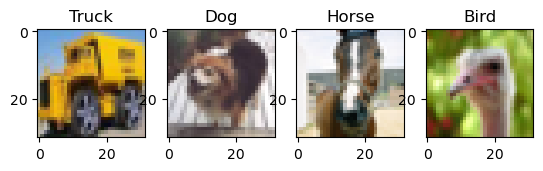

In [8]:
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i].movedim(0,-1)*0.5+0.5)
    plt.title(CLASSES[labels[i]])

## Model

Consider the layers which change the dimensions :

In [9]:
# Input = (m, 3, 32, 32)

print("Input shape : ", images.shape)

conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
tens = conv1(images)
print("After conv1 : ", tens.shape)

pool = nn.MaxPool2d(kernel_size=2, stride=2)
tens = pool(tens)
print("After pool : ", tens.shape)

conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
tens = conv2(tens)
print("After conv2 : ", tens.shape)

tens = pool(tens)
print("After pool : ", tens.shape)

# Output shape = (m, 16, 5, 5)

Input shape :  torch.Size([4, 3, 32, 32])
After conv1 :  torch.Size([4, 6, 28, 28])
After pool :  torch.Size([4, 6, 14, 14])
After conv2 :  torch.Size([4, 16, 10, 10])
After pool :  torch.Size([4, 16, 5, 5])


Two Methods to Flatten Data

In [10]:
flat = tens.flatten(start_dim=1)            # Caused an error in plotting
print("After flatten : ", flat.shape)

flat = tens.view(-1, 16*5*5)                # Use this
print("After flatten : ", flat.shape)

After flatten :  torch.Size([4, 400])
After flatten :  torch.Size([4, 400])


In [11]:
class ConvNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # Convolution part
        z = nn.functional.relu(self.conv1(x))
        z = self.pool(z)
        z = nn.functional.relu(self.conv2(z))
        z = self.pool(z)

        # Flatten
        z = z.view(-1, 16*5*5)

        # Fully Connected Part
        z = nn.functional.relu(self.fc1(z))
        z = nn.functional.relu(self.fc2(z))
        z = self.fc3(z)
        return z


In [12]:
model = ConvNet()

### Print Model Summary

In [13]:
torchsummary.summary(model, (3, 32, 32), device=torch.device("cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
           ConvNet-8                   [-1, 10]               0
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------



(tensor(62006), tensor(62006))

### Output Model Graph

In [14]:
input_names = ['CIFAR10 Image']
output_names = ['Class']
x = torch.rand((3, 32, 32))
torch.onnx.export(model, x, './models/conv_net.onnx', input_names=input_names, output_names=output_names)

## Loss and Optimizer

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [16]:
n_total_steps = len(train_loader)
print(n_total_steps)

12500


In [17]:
losses = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        
        if (i+1) % 2500 == 0:
            print(f"epoch = {epoch+1}, mini-batch = {i+1}, loss = {loss.item():.4f}")
    print(f"Epoch {epoch+1} Complete!")

epoch = 1, mini-batch = 2500, loss = 1.8259
epoch = 1, mini-batch = 5000, loss = 0.9850
epoch = 1, mini-batch = 7500, loss = 1.1069
epoch = 1, mini-batch = 10000, loss = 3.0209
epoch = 1, mini-batch = 12500, loss = 1.4863
Epoch 1 Complete!
epoch = 2, mini-batch = 2500, loss = 0.4299
epoch = 2, mini-batch = 5000, loss = 1.5899
epoch = 2, mini-batch = 7500, loss = 1.5835
epoch = 2, mini-batch = 10000, loss = 2.0693
epoch = 2, mini-batch = 12500, loss = 1.2735
Epoch 2 Complete!
epoch = 3, mini-batch = 2500, loss = 1.0141
epoch = 3, mini-batch = 5000, loss = 1.5064
epoch = 3, mini-batch = 7500, loss = 1.5293
epoch = 3, mini-batch = 10000, loss = 0.4003
epoch = 3, mini-batch = 12500, loss = 2.0466
Epoch 3 Complete!
epoch = 4, mini-batch = 2500, loss = 1.0162
epoch = 4, mini-batch = 5000, loss = 1.8804
epoch = 4, mini-batch = 7500, loss = 3.1314
epoch = 4, mini-batch = 10000, loss = 0.4155
epoch = 4, mini-batch = 12500, loss = 1.1406
Epoch 4 Complete!
epoch = 5, mini-batch = 2500, loss = 1.1

Text(0, 0.5, 'loss')

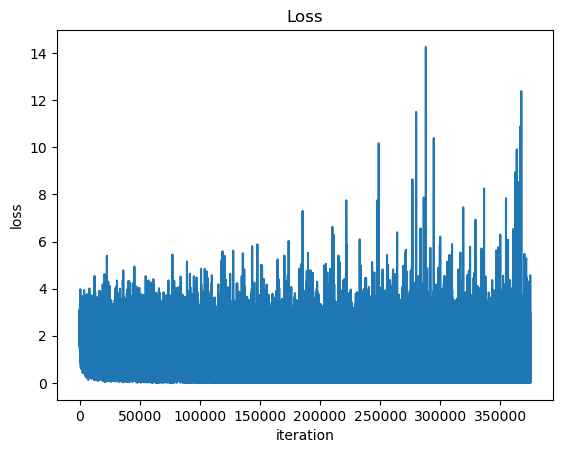

In [18]:
plt.plot(losses)
plt.title("Loss")
plt.xlabel("iteration")
plt.ylabel("loss")

## Testing

In [19]:
print("Output shape : ", outputs.shape)

_, predictions = torch.max(outputs, dim=1)      # keepDims=False by default
print("Prediction shape : ", predictions.shape)

print("Label shape : ", labels.shape)

Output shape :  torch.Size([4, 10])
Prediction shape :  torch.Size([4])
Label shape :  torch.Size([4])


In [20]:
with torch.no_grad():
    n_correct = 0
    n_total = 0
    n_class_correct = [0]*len(CLASSES)
    n_class_total = [0]*len(CLASSES)
    for images, labels in test_loader:
        outputs = model(images)
        _, predictions = torch.max(outputs, dim=1)

        n_total += outputs.shape[0]
        n_correct += (predictions==labels).sum().item()

        for i in range(batch_size):
            n_class_total[labels[i]] += 1
            n_class_correct[labels[i]] += 1 if labels[i]==predictions[i] else 0

acc = 100.0*n_correct/n_total

print(f'Accuracy = {acc:.2f}%')

Accuracy = 60.79%


In [21]:
print("Class wise accuracies :")
print("")
acc_class = [0]*10
for i in range(len(CLASSES)):
    acc_class = 100.0*n_class_correct[i]/n_class_total[i]
    print(f'\t {CLASSES[i]} \t {acc_class}%')

Class wise accuracies :

	 Plane 	 64.4%
	 Car 	 72.4%
	 Bird 	 55.3%
	 Cat 	 40.5%
	 Deer 	 45.4%
	 Dog 	 55.3%
	 Frog 	 69.1%
	 Horse 	 62.6%
	 Ship 	 69.0%
	 Truck 	 73.9%


Train for more epochs to obtain a better accuracy

### After 4 epochs:

	Accuracy = 59.17%

	 Plane 	 73.1%
	 Car 	 59.0%
	 Bird 	 45.5%
	 Cat 	 45.2%
	 Deer 	 57.4%
	 Dog 	 45.7%
	 Frog 	 73.2%
	 Horse 	 56.0%
	 Ship 	 70.2%
	 Truck 	 66.4%

### After 30 epochs:

	 Accuracy = 60.79%

     Plane 	 64.4%
	 Car 	 72.4%
	 Bird 	 55.3%
	 Cat 	 40.5%
	 Deer 	 45.4%
	 Dog 	 55.3%
	 Frog 	 69.1%
	 Horse 	 62.6%
	 Ship 	 69.0%
	 Truck 	 73.9%